# Understanding Hired Rides in NYC



## Project Setup

In [1]:
# All import statements needed for the project

import math

import re
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import pyarrow.parquet as pq
import geopandas as gpd
import geopy.distance
import os
import sqlalchemy as db
import numpy as np
import scipy
from keplergl import KeplerGl
import seaborn as sns

In [2]:
# All constraints we need

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"
TAXI_ZONES_PATH = 'taxi_zones.shp'
WEATHER_CSVS = ["2009_weather.csv", "2010_weather.csv", "2011_weather.csv", 
               "2012_weather.csv", "2013_weather.csv", "2014_weather.csv", "2015_weather.csv"]
CLEAN_TAXI_DATA_PATH = 'Clean_Taxi_Data.csv'

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

# Dict to normalize the column names
NORMALIZE_DICT = {
    'VendorID': 'vendor_id',
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime',
    'RatecodeID': 'rate_code',
    'Trip_Pickup_DateTime': 'pickup_datetime',
    'Trip_Dropoff_DateTime': 'dropoff_datetime',
    'Start_Lon': 'pickup_longitude',
    'Start_Lat': 'pickup_latitude',
    'End_Lon': 'dropoff_longitude',
    'End_Lat': 'dropoff_latitude',
    'Fare_Amt': 'fare_amount',
    'Tip_Amt': 'tip_amount',
    'Tolls_Amt': 'tolls_amount',
    'Total_Amt': 'total_amount',
    'pickup_latitude': 'pickup_latitude',
    'pickup_longitude': 'pickup_longitude',
    'dropoff_latitude': 'dropoff_latitude',
    'dropoff_longitude': 'dropoff_longitude'
}

# Features used in taxi dataset
TAXI_FEATURES = ['pickup_datetime','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'tip_amount']
# Features used in uber dataset
UBER_FEATURES = ['pickup_datetime','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
# Features used in weather dataset
WEATHER_FEATURES = ['DATE','HourlyWindSpeed','HourlyPrecipitation']
# Features used in sunrise/sunset data
SUN_FEATURES = ['DATE','Sunrise','Sunset']

# Sample size for each taxi dataset
SAMPLE_SIZE = (round(200000/78), 200000-78*round(200000/78))

# Define the radius of the Earth in kilometers
R_EARTH = 6371 

# BBOX setting
LGA_BBOX = [-73.889473,40.766102,-73.857630,40.782806,'LGA']
JFK_BBOX = [-73.826978,40.618945,-73.741319,40.673388,'JFK']
EWR_BBOX = [-74.199343,40.668791,-74.150248,40.712069,'EWR']

In [3]:
# Load the texi zones data
Taxi_zones = gpd.read_file(TAXI_ZONES_PATH).to_crs(4326)
Taxi_zones['longitude'] = Taxi_zones.centroid.x  
Taxi_zones['latitude'] = Taxi_zones.centroid.y

<ipython-input-3-ad86acdb1b79>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Taxi_zones['longitude'] = Taxi_zones.centroid.x
<ipython-input-3-ad86acdb1b79>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Taxi_zones['latitude'] = Taxi_zones.centroid.y


## Part 1: Data Preprocessing

In part 1, we will do the following data preprocessing steps:
1. Download the taxi data from 2009-01 to 2015-06 from the NYC Taxi & Limousine Commission website programmatically.
1. Add a new column to the taxi and uber datasets representing the distance of the trip. We calculate the distance using latitude and longitude of the pick-up location and drop-off location.
3. Load and clean the taxi data, uber data, and the weather data

### Calculating distance
We can use the Haversine formula to calculate the distance. The formula is:
$$d = 2rarcsin(\sqrt{sin^{2}(\frac{\phi_{2}-\phi_{1}}{2})+cos(\phi_{1})cos(\phi_{2})sin^{2}(\frac{\lambda_{2}-\lambda_{1}}{2})}$$
where $r$ is the radius of earth, $\phi$ is the latitude and $\lambda$ is the longitude.

In [4]:
def calculate_distance(from_coord, to_coord):
    # Convert the latitude and longitude of each point to radians
    lat1, lon1 = map(math.radians, from_coord)
    lat2, lon2 = map(math.radians, to_coord)
    
    # Calculate the difference between the latitudes and longitudes of the two points in radians
    lat_diff = lat2 - lat1
    lon_diff = lon2 - lon1
    
    # Calculate the central angle of the two points using the haversine formula
    a = math.sin(lat_diff / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(lon_diff / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Calculate the geodesic distance between the two points using the central angle and the radius of the Earth
    dist = R_EARTH * c
    return dist

Then we write a function to add a 'distance' column to the dataframe using the above function.

In [5]:
def convert_coord(row):
    """Tool function."""
    
    from_coord = (row['pickup_latitude'], row['pickup_longitude'])
    to_coord = (row['dropoff_latitude'], row['dropoff_longitude'])
    return from_coord, to_coord

def add_distance_column(dataframe):
    dataframe['distance'] = dataframe.apply(lambda row: calculate_distance(convert_coord(row)[0], convert_coord(row)[1]), axis=1)

### Processing Taxi Data

Firstly, we need to download all the data from the website. To do this, we parse all the urls needed for the taxi data.

In [6]:
def find_taxi_csv_urls():
    response = requests.get(TAXI_URL)
    html = response.content
    soup = bs4.BeautifulSoup(html, 'html.parser')
    prefix = 'yellow_tripdata_20'
    pattern = fr'{prefix}09|{prefix}1[0-4]|{prefix}15-0[1-6]'
    urls = []
    for a in soup.find_all("a", href = True):
        url_text = a.get("href")
        matches = re.findall(pattern, url_text)
        if matches:
            urls.append(url_text)
    return urls

urls = find_taxi_csv_urls()

This function is used to download/load a singal dataset using the url and performs the cleaning. We first check if the file has already been download. In this case, we simply load the file from the disk and convert it to a dataframe. To be consistent with the uber dataset, we replace all the location IDs with the explicit latitude and longitude information and remove the ID columns. For those records with invalid location ID or invalid location information (outside New York City), we remove them from the dataset. Meanwhile, we add a column showing the distance of the trip.

Moreover, we normalize the column names of the dataset. In particular, columns with location information are named the same as those in uber dataset. To conduct a fair comparison, we sample each dataset to make the entire dataset have equal size with the uber dataset.

In [7]:
def get_and_clean_month_taxi_data(url):
    # Get the file name
    file_name = url.split('/')[-1]

    # Download only once
    if os.path.exists(file_name)==False:
        print(f'Downloading {file_name}')
        file = requests.get(url)
        with open(file_name , 'wb') as f:
            f.write(file.content)
    else:
        print(f'{file_name} already downloaded.')

    # Read the parquet file and transform it into a dataframe
    data = pq.read_table(file_name)
    data_df = data.to_pandas()

    # If ID is used to record the location, replace the ID with explicit latitude and longitude
    if 'DOLocationID' in data_df.columns:
        data_df['pickup_latitude'] = data_df['PULocationID'].map(Taxi_zones['latitude'], na_action = 'ignore')
        data_df['pickup_longitude'] = data_df['PULocationID'].map(Taxi_zones['longitude'], na_action = 'ignore')
        data_df['dropoff_latitude'] = data_df['DOLocationID'].map(Taxi_zones['latitude'], na_action = 'ignore')
        data_df['dropoff_longitude'] = data_df['DOLocationID'].map(Taxi_zones['longitude'], na_action = 'ignore')
        
        #Remove the ID columns
        data_df = data_df.drop(['DOLocationID', 'PULocationID'], axis=1)

        # Remove records with invalid ID
        data_df = data_df.dropna(subset=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

        #Remove records with invalid location
        data_df = data_df[data_df.pickup_latitude.between(NEW_YORK_BOX_COORDS[0][0], NEW_YORK_BOX_COORDS[1][0])\
                    & data_df.pickup_longitude.between(NEW_YORK_BOX_COORDS[0][1], NEW_YORK_BOX_COORDS[1][1])\
                    & data_df.dropoff_latitude.between(NEW_YORK_BOX_COORDS[0][0], NEW_YORK_BOX_COORDS[1][0])\
                    & data_df.dropoff_longitude.between(NEW_YORK_BOX_COORDS[0][1], NEW_YORK_BOX_COORDS[1][1])]

    # Normalize the column names    
    data_df = data_df.rename(columns = NORMALIZE_DICT)
    
    # Remove useless columns
    data_df = data_df[TAXI_FEATURES]
    
    # Removing invalid data points
    data_df = data_df[(data_df['tip_amount'] >= 0)]

    # Sample the dataset
    data_df = data_df.sample(SAMPLE_SIZE[1] if file_name=='yellow_tripdata_2015-06.parquet' else SAMPLE_SIZE[0]) 
    
    # Normalize data
    data_df['pickup_datetime'] = pd.to_datetime(data_df['pickup_datetime'])
    data_type = 'float32'
    data_df = data_df.astype({'pickup_longitude':data_type,'pickup_latitude':data_type,'dropoff_longitude':data_type,'dropoff_latitude':data_type,'tip_amount':data_type})

    return data_df

In [8]:
def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    
    all_csv_urls = find_taxi_csv_urls()
    for csv_url in all_csv_urls:
        dataframe = get_and_clean_month_taxi_data(csv_url)
        add_distance_column(dataframe)
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    taxi_data.to_csv(CLEAN_TAXI_DATA_PATH)
    return taxi_data

### Processing Uber Data
In this section, we pre-process the Uber Data. We perform similar operations to clean the location information. Some useless features are removed from the dataset. The names of the rest are stored in *UBER_FEATURES*. 

In [9]:
def load_and_clean_uber_data(csv_file):
    data_df = pd.read_csv(csv_file)
    
    # Remove records with invalid location
    data_df = data_df.dropna(subset=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
    
    # Remove useless columns
    data_df = data_df[UBER_FEATURES]
    
    #Remove records with invalid location
    data_df = data_df[data_df.pickup_latitude.between(NEW_YORK_BOX_COORDS[0][0], NEW_YORK_BOX_COORDS[1][0])\
                & data_df.pickup_longitude.between(NEW_YORK_BOX_COORDS[0][1], NEW_YORK_BOX_COORDS[1][1])\
                & data_df.dropoff_latitude.between(NEW_YORK_BOX_COORDS[0][0], NEW_YORK_BOX_COORDS[1][0])\
                & data_df.dropoff_longitude.between(NEW_YORK_BOX_COORDS[0][1], NEW_YORK_BOX_COORDS[1][1])]
    
    # Normalizing data 
    data_df['pickup_datetime'] = pd.to_datetime(data_df['pickup_datetime'])
    data_type = 'float32'
    data_df = data_df.astype({'pickup_longitude':data_type,'pickup_latitude':data_type,'dropoff_longitude':data_type,'dropoff_latitude':data_type})
    
    return data_df

In [10]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    
    return uber_dataframe

### Processing Weather Data

Then we deal with the weather data. The original data is grouped by hour. To have a more comprehensive exploration, we further create a new dataset grouping the weather data by day, 

In [11]:
def clean_month_weather_data_hourly(csv_file):
    """Data by hour."""
    
    # Load data
    data_df = pd.read_csv(csv_file, low_memory=False)
    
    # Remove useless columns
    data_df = data_df[WEATHER_FEATURES]
    
    # Normalize data
    data_df['DATE'] = pd.to_datetime(data_df['DATE'])
    data_df['HourlyPrecipitation'] = pd.to_numeric(data_df['HourlyPrecipitation'], errors='coerce')
    
    # Remove missing values
    data_df = data_df.dropna(subset=['HourlyWindSpeed'])
    
    # Fill 0 to NAs in the precipitation data
    data_df["HourlyPrecipitation"] = data_df["HourlyPrecipitation"].fillna(0)
    
    data_type = 'float32'
    data_df = data_df.astype({'HourlyWindSpeed': data_type, 'HourlyPrecipitation': data_type})

    return data_df


In [12]:
def clean_month_weather_data_daily(csv_file):
    """Data by day."""
    
    data_df = pd.read_csv(csv_file, low_memory=False)
    
    data_df = data_df[WEATHER_FEATURES]
    
    # Normalize data
    data_df['DATE'] = pd.to_datetime(data_df['DATE'])
    data_df['HourlyPrecipitation'] = pd.to_numeric(data_df['HourlyPrecipitation'], errors='coerce')
    
    # Fill 0 to NAs in the precipitation data
    data_df["HourlyPrecipitation"] = data_df["HourlyPrecipitation"].fillna(0)
    
    # Group by hour and take the mean of the windspeed and sum of the precipitation
    data_df['DATE'] = data_df['DATE'].dt.date
    data_df = data_df.groupby('DATE', as_index=False).agg(
        {'HourlyWindSpeed': np.mean,
        'HourlyPrecipitation': np.sum}
    )

    
    data_df = data_df.rename(columns={'HourlyWindSpeed': 'DailyWindSpeed', 'HourlyPrecipitation': 'DailyPrecipitation'})
    data_df['DATE'] = pd.to_datetime(data_df['DATE'])
    
    return data_df
    

In [13]:
def load_and_clean_weather_data():
    """Process all weather data"""
    
    hourly_dataframes = []
    daily_dataframes = []
    
    for csv_file in WEATHER_CSVS:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    return hourly_data, daily_data

### Process All Data

We pre-process and store all the data for later use.

In [14]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

## Part 2: Storing Cleaned Data

In part 2, we store all the data obtained in part 1 to a database. We keep the data types the same.

In [15]:
engine = db.create_engine(DATABASE_URL)

We create four related table in the database and save the table schema locally in the file _schema.sql_.

In [16]:
TAXI_TRIPS_SCHEMA = """
    CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    pickup_longitude FLOAT32,
    pickup_latitude FLOAT32,
    dropoff_longitude FLOAT32,
    dropoff_latitude FLOAT32,
    tip_amount FLOAT32,
    distance FLOAT32
);
"""

UBER_TRIPS_SCHEMA = """
    CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    pickup_longitude FLOAT32,
    pickup_latitude FLOAT32,
    dropoff_longitude FLOAT32,
    dropoff_latitude FLOAT32,
    distance FLOAT32
);
"""

HOURLY_WEATHER_SCHEMA = """
    CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    HourlyWindSpeed FLOAT32,
    HourlyPrecipitation FLOAT32
);
"""

DAILY_WEATHER_SCHEMA = """
    CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    DailyWindSpeed FLOAT32,
    DailyPrecipitation FLOAT32
);
"""

In [17]:
# Create schema files
with open(DATABASE_SCHEMA_FILE, 'w') as f:
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    

In [18]:
# Create tables using the schema files.
with engine.connect() as connection:
    with open(DATABASE_SCHEMA_FILE, 'r') as f:
        queries = f.read().split(';')
        for query in queries:
            connection.execute(db.text(query))

### Add Data to Database

Add corresponding data to the database

In [19]:
def write_dataframes_to_table(table_to_df_dict):
    for table, df in table_to_df_dict.items():
        df.to_sql(table, engine, if_exists='append', index=False)

In [20]:
table_to_df_dict = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [21]:
write_dataframes_to_table(table_to_df_dict)

## Part 3: Understanding the Data

Now that we store all the data in a database, we can make queries in order to understand the data.

In [22]:
def write_query_to_file(query, outfile):
    with open(QUERY_DIRECTORY + outfile, "w") as f:
        f.write(query)

### Query 1

For 01-2009 through 06-2015, what hour of the day was the most popular to take a
Yellow Taxi?

In [23]:
QUERY_1 = """
    SELECT strftime('%H', pickup_datetime) AS time, COUNT(*) AS count
    FROM taxi_trips
    GROUP BY time
    ORDER BY count DESC;
"""


In [24]:
engine.execute(QUERY_1).fetchall()

[('19', 12435),
 ('18', 12023),
 ('20', 11658),
 ('21', 11369),
 ('22', 11254),
 ('23', 9954),
 ('14', 9817),
 ('17', 9674),
 ('13', 9618),
 ('12', 9559),
 ('15', 9440),
 ('09', 9221),
 ('08', 8985),
 ('11', 8896),
 ('10', 8744),
 ('16', 8219),
 ('00', 7803),
 ('07', 7140),
 ('01', 5800),
 ('02', 4420),
 ('06', 4074),
 ('03', 3112),
 ('04', 2386),
 ('05', 1835)]

In [25]:
write_query_to_file(QUERY_1, "most_popular_hour.sql")

### Query 2

For the same time frame, what day of the week was the most popular to take an Uber?


In [26]:
QUERY_2 = """
    SELECT strftime('%w', pickup_datetime) AS time, COUNT(*) AS count
    FROM uber_trips
    GROUP BY time
    ORDER BY count DESC;
"""

In [27]:
engine.execute(QUERY_2).fetchall()

[('5', 30166),
 ('6', 29599),
 ('4', 29338),
 ('3', 28328),
 ('2', 27526),
 ('0', 25834),
 ('1', 24681)]

In [28]:
write_query_to_file(QUERY_2, "most_popular_day.sql")

### Query 3

What is the 95% percentile of distance traveled for all hired trips during July 2013?


In [29]:
QUERY_3 = """
    WITH hired_trips AS (
        SELECT pickup_datetime, distance
        FROM taxi_trips
        WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-08-01'
        UNION ALL
        SELECT pickup_datetime, distance
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-08-01'
    )
    SELECT distance
    FROM hired_trips
    ORDER BY distance ASC
    LIMIT 1
    OFFSET (SELECT COUNT(*) FROM hired_trips) * 95 / 100 - 1;
"""


In [30]:
engine.execute(QUERY_3).fetchall()

[(23.034391788471975,)]

In [31]:
write_query_to_file(QUERY_3, "95%_percentile_distance.sql")

### Query 4

What were the top 10 days with the highest number of hired rides for 2009, and what
was the average distance for each day?

In [32]:
QUERY_4 = """
    WITH hired_trips AS (
        SELECT pickup_datetime, distance
        FROM taxi_trips
        WHERE pickup_datetime BETWEEN '2009-01-01' AND '2010-01-01'
        UNION ALL
        SELECT pickup_datetime, distance
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2009-01-01' AND '2010-01-01'
    )
    SELECT date(pickup_datetime) AS time, AVG(distance) AS avg_distance, COUNT(*) AS count
    FROM hired_trips
    GROUP BY time
    ORDER BY count DESC
    LIMIT 10;
"""


In [33]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 3.630619146217639, 236),
 ('2009-02-20', 2.783413451473398, 227),
 ('2009-04-04', 3.0636344086658185, 221),
 ('2009-02-12', 2.740752741633371, 218),
 ('2009-11-05', 4.027002040459544, 216),
 ('2009-10-23', 3.106935674467926, 214),
 ('2009-08-14', 3.402809243287893, 213),
 ('2009-01-31', 2.978511011839767, 213),
 ('2009-12-18', 3.27061967781808, 212),
 ('2009-12-05', 2.7230583709753033, 212)]

In [34]:
write_query_to_file(QUERY_4, "top_10_days.sql")

### Query 5

Which 10 days in 2014 were the windiest on average, and how many hired trips were
made on those days?

In [35]:
QUERY_5 = """
    SELECT date(pickup_datetime) AS date, COUNT(*) AS count
    FROM (
        SELECT pickup_datetime
        FROM taxi_trips
        UNION ALL
        SELECT pickup_datetime
        FROM uber_trips
    )
    GROUP BY date
    HAVING date IN (
        SELECT date(DATE)
        FROM daily_weather
        WHERE DATE BETWEEN '2014-01-01' AND '2015-01-01'
        ORDER BY DailyWindSpeed DESC
        LIMIT 10
    )
"""


In [36]:
engine.execute(QUERY_5).fetchall()

[('2014-01-02', 121),
 ('2014-01-07', 159),
 ('2014-02-13', 121),
 ('2014-03-13', 211),
 ('2014-03-26', 173),
 ('2014-03-29', 204),
 ('2014-11-02', 146),
 ('2014-12-07', 174),
 ('2014-12-08', 161),
 ('2014-12-09', 152)]

In [37]:
write_query_to_file(QUERY_5, "top_10_windiest_days.sql")

### Query 6

During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the
week after, how many trips were taken each hour, and for each hour, how much
precipitation did NYC receive and what was the sustained wind speed?

In [38]:
QUERY_6 = """
    WITH hired_trips AS (
        SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS date
        FROM taxi_trips
        WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-07'
        UNION ALL
        SELECT  strftime('%Y-%m-%d %H', pickup_datetime)
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-07'
    )
    SELECT strftime('%Y-%m-%d %H', hourly_weather.DATE) AS wea_date, COALESCE(COUNT(hired_trips.DATE), 0) AS count, HourlyPrecipitation, HourlyWindSpeed
    FROM hourly_weather
    LEFT JOIN hired_trips
    ON wea_date = hired_trips.DATE
    WHERE wea_date BETWEEN '2012-10-22' AND '2012-11-07'
    GROUP BY wea_date
"""


In [39]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00', 2, 0.0, 7.0),
 ('2012-10-22 01', 0, 0.0, 5.0),
 ('2012-10-22 02', 2, 0.0, 7.0),
 ('2012-10-22 03', 1, 0.0, 0.0),
 ('2012-10-22 04', 0, 0.0, 0.0),
 ('2012-10-22 05', 3, 0.0, 0.0),
 ('2012-10-22 06', 5, 0.0, 5.0),
 ('2012-10-22 07', 8, 0.0, 3.0),
 ('2012-10-22 08', 8, 0.0, 3.0),
 ('2012-10-22 09', 11, 0.0, 5.0),
 ('2012-10-22 12', 10, 0.0, 11.0),
 ('2012-10-22 14', 4, 0.0, 7.0),
 ('2012-10-22 15', 2, 0.0, 6.0),
 ('2012-10-22 16', 10, 0.0, 3.0),
 ('2012-10-22 17', 8, 0.0, 7.0),
 ('2012-10-22 18', 12, 0.0, 5.0),
 ('2012-10-22 19', 8, 0.0, 5.0),
 ('2012-10-22 20', 8, 0.0, 3.0),
 ('2012-10-22 21', 6, 0.0, 0.0),
 ('2012-10-22 22', 12, 0.0, 3.0),
 ('2012-10-22 23', 2, 0.0, 3.0),
 ('2012-10-23 00', 4, 0.0, 3.0),
 ('2012-10-23 01', 2, 0.0, 0.0),
 ('2012-10-23 02', 0, 0.0, 3.0),
 ('2012-10-23 03', 2, 0.0, 0.0),
 ('2012-10-23 04', 1, 0.0, 3.0),
 ('2012-10-23 05', 3, 0.0, 0.0),
 ('2012-10-23 06', 5, 0.0, 0.0),
 ('2012-10-23 07', 13, 0.0, 0.0),
 ('2012-10-23 08', 14, 0.0, 0.0),
 (

In [40]:
write_query_to_file(QUERY_6, "hurricane_sandy.sql")

## Part 4: Visualizing the Data



### Visualization 1

We will create a line chart to show the most popular hour of the day to take a yellow taxi. 

In [41]:
plt.style.use('ggplot')

In [42]:
def popular_hour_taxi(dataframe):
    plt.plot(dataframe[['time']].to_numpy().reshape(-1,), dataframe[['count']].to_numpy().reshape(-1,))
    plt.xlabel('Hour')
    plt.ylabel('Number of Trips')
    plt.title("Taxi Trips Count per Hour")
    plt.show()

In [43]:
def get_data_for_popular_hour_taxi():
    """Read data from the database."""
    
    df = pd.read_sql_query(QUERY_1, engine).sort_values(by="time", ascending=True)
    
    return df

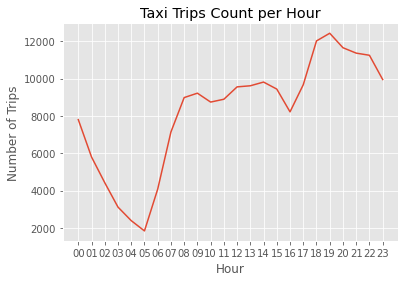

In [44]:
df = get_data_for_popular_hour_taxi()
popular_hour_taxi(df)

### Visualization 2

We will create a line chart to display the average distance traveled per month and the 90% confidence interval around the mean. 


In [45]:
def avg_distance_per_month(taxi_df, uber_df):
    """Make a line chart to display the average distance traveled per month and the 90% confidence interval around the mean"""
    
    # change the data type of the year_month column to datetime
    format_type = '%Y-%m'
    taxi_df['time'] = pd.to_datetime(taxi_df['time'], format=format_type)
    uber_df['time'] = pd.to_datetime(uber_df['time'], format=format_type)
    
    # Calculate the 90% confidence interval of Uber data
    uber_df = uber_df['num'].groupby(uber_df['time'].dt.month).agg(['mean', 'count', 'sem'])
    uber_df['dof'] = uber_df['count'] - 1
    uber_l, uber_h = scipy.stats.t.interval(0.90, uber_df['dof'], loc=uber_df['mean'], scale=uber_df['sem'])
    
    # Calculate the 90% confidence interval of taxi data
    taxi_df = taxi_df['num'].groupby(taxi_df['time'].dt.month).agg(['mean', 'count', 'sem'])
    taxi_df['dof'] = taxi_df['count'] - 1
    taxi_l, taxi_h = scipy.stats.t.interval(0.90, taxi_df['dof'], loc=taxi_df['mean'], scale=taxi_df['sem'])

    # Plot
    plt.plot(taxi_df.index, taxi_df['mean'], label='Taxi')
    plt.plot(uber_df.index, uber_df['mean'], label='Uber')
    plt.fill_between(taxi_df.index, taxi_l, taxi_h, alpha=0.4)
    plt.fill_between(uber_df.index, uber_l, uber_h, alpha=0.4)
    
    plt.title('Average Distance Traveled per Month'); plt.xlabel('Month'); plt.ylabel('Average Distance Traveled'); plt.legend()
    plt.show()


In [46]:
def get_data_for_avg_distance_per_month():
    """Read data from the database."""
    
    taxi_query="""
        SELECT strftime('%Y-%m', pickup_datetime) AS time, SUM(distance) AS num
        FROM taxi_trips
        GROUP BY time
    """

    uber_query="""
        SELECT strftime('%Y-%m', pickup_datetime) AS time, SUM(distance) AS num
        FROM uber_trips
        GROUP BY time
    """
    
    # get the data from the database
    taxi_df = pd.read_sql_query(taxi_query, engine)
    uber_df = pd.read_sql_query(uber_query, engine)
    return taxi_df, uber_df

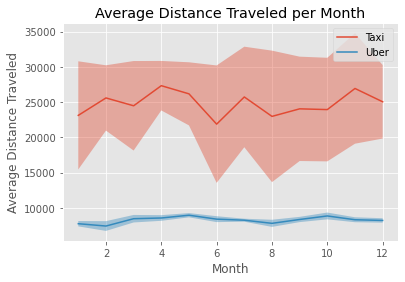

In [47]:
taxi_df, uber_df = get_data_for_avg_distance_per_month()
avg_distance_per_month(taxi_df, uber_df)

### Visualization 3

We define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR and create a bar chart that compares what day of the week was most popular for drop offs for each airport. In the bar chart, each color represents a type of coordinate boxes.

In [48]:
def dropoff_num_per_day(dfs):
    """Make a bar plot to show the number of dropoffs per day."""
    
    names = ['LGA','JFK','EWR']
    x = dfs[0][['day']].to_numpy().reshape(-1,)
    y = [dfs[i][[num]].to_numpy().reshape(-1,) for i, num in enumerate(names)]
    for i in range(3):
        plt.bar(x, y[i])
    plt.xlabel('Day')
    plt.ylabel('Number of Dropoffs')
    plt.title("Number of Dropoffs Per Day for Every Airport")
    plt.legend(names)
    plt.show()

In [49]:
def get_data_for_dropoff_num_per_day():
    """Read data from the database."""

    dfs = []
    for BBOX in [LGA_BBOX, JFK_BBOX, EWR_BBOX]:
        query = f"""
            WITH hired_trips AS (SELECT pickup_datetime,dropoff_longitude,dropoff_latitude
            FROM taxi_trips UNION ALL
            SELECT pickup_datetime,dropoff_longitude,dropoff_latitude FROM uber_trips)
            SELECT strftime('%w', pickup_datetime) AS day ,COUNT(*) AS {BBOX[4]}
            FROM hired_trips
            WHERE dropoff_longitude BETWEEN {BBOX[0]} AND {BBOX[2]} AND dropoff_latitude BETWEEN {BBOX[1]} AND {BBOX[3]}
            GROUP BY day
        """
        dfs.append(pd.read_sql_query(query, engine))
    return dfs

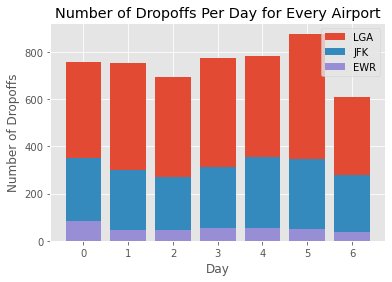

In [50]:
dfs = get_data_for_dropoff_num_per_day()
dropoff_num_per_day(dfs)

### Visualization 4

Create a heatmap of all hired trips over a map of the area. This can show us which places are more popular.

In [51]:
def heatmap_of_trips(df):
    """Make a heatmap of all hired trips over a map of the area."""
    # Reindex
    location = Taxi_zones.reset_index()

    # Merge two dataframes
    location['square'] = location['latitude']**2 +  location['longitude']**2
    location = location.sort_values(by='square')
    df['square'] = df['latitude']**2 +  df['longitude']**2
    df = df.sort_values(by='square')
    df = pd.merge_asof(df, location, left_on=['square'], right_on=['square'])
    
    # Remove invalid records
    df.dropna(subset=['LocationID'], inplace=True)

    location['num'] = df.groupby('LocationID').count()['square']
    
    location.plot(column='num', cmap='tab20c', legend=True, markersize = 10)
    
    plt.show()
    
    return location

In [52]:
def get_data_for_heatmap_of_trips():
    """Read data from the database"""
    
    query = """
        WITH hired_trips AS (SELECT pickup_latitude AS latitude, pickup_longitude AS longitude
        FROM taxi_trips UNION ALL
        SELECT pickup_latitude AS latitude, pickup_longitude AS longitude FROM uber_trips)
        SELECT latitude, longitude
        FROM hired_trips
    """
    
    df = pd.read_sql_query(query, engine)
    
    return df

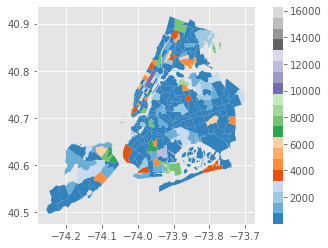

In [53]:
df = get_data_for_heatmap_of_trips()
location = heatmap_of_trips(df)

In [54]:
# use Kepler to make a heatmap
map = KeplerGl(height=500,data={'NYC':location})
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'NYC':      index  OBJECTID  Shape_Leng  Shape_Area                     zone  \
85      85     …

### Visualization 5

We create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. 

In [55]:
# use a more descriptive name for your function
def tip_amount_vs_distance(df):
    """Make a scatter plot to compare tip amount and the distance"""
    
    # Remove outlier
    df = df[(df['distance'] < 50) & (df['tip_amount'] > 0)]
    plt.scatter(df[['distance']].to_numpy().reshape(-1,), df[['tip_amount']].to_numpy().reshape(-1,), alpha=0.3)
    plt.xlabel('Distance')
    plt.ylabel('Tip Amount')
    plt.title("Tip Amount vs Distance")
    plt.show()


In [56]:
def get_data_for_tip_amount_vs_distance():
    """Read data from the database"""
    
    query = """
        SELECT tip_amount, distance
        FROM taxi_trips
    """
    df = pd.read_sql_query(query, engine)
    
    return df

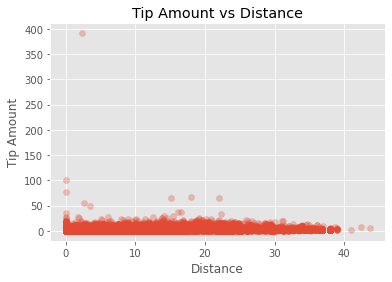

In [57]:
df = get_data_for_tip_amount_vs_distance()
tip_amount_vs_distance(df)

### Visualization 6

We create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. 

In [58]:
def tip_amount_vs_precipitation(df):
    """Make a scatter plot to compare tip amount and the precipitation"""

    plt.scatter(df[['HourlyPrecipitation']].to_numpy().reshape(-1,), df[['tip_amount']].to_numpy().reshape(-1,), color='pink')
    plt.xlabel('Precipitation')
    plt.ylabel('Tip Amount')
    plt.title("Tip Amount vs Precipitation")
    plt.show()

In [59]:
def get_data_for_tip_amount_vs_precipitation():
    """Read data from the database"""
    
    query1 = """
        SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS date, tip_amount
        FROM taxi_trips
    """ 
    query2 = """
        SELECT strftime('%Y-%m-%d %H', DATE) AS date, HourlyPrecipitation
        FROM hourly_weather
    """
    taxi_data = pd.read_sql_query(query1, engine)
    weather_data = pd.read_sql_query(query2, engine)
    df = pd.merge(taxi_data, weather_data, on='date')
    
    df = df[(df['HourlyPrecipitation'] > 0) & (df['tip_amount'] < 50)]
    
    return df

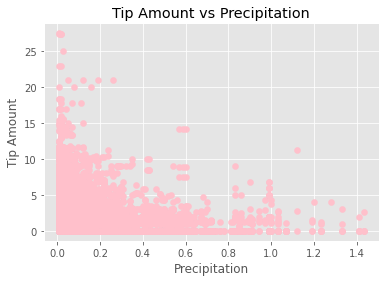

In [60]:
df = get_data_for_tip_amount_vs_precipitation()
tip_amount_vs_precipitation(df)